## Clustering Grocery Items

### Goal

Online shops often sell tons of different items and this can become very messy very quickly!

Data science can be extremely useful to automatically organize the products in categories so that they can be easily found by the customers.

The goal of this challenge is to look at user purchase history and create categories of items that are likely to be bought together and, therefore, should belong to the same section.

### Challenge Description

Company XYZ is an online grocery store. In the current version of the website, they have manually grouped the items into a few categories based on their experience.

However, they now have a lot of data about user purchase history. Therefore, they would like to put the data into use!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics

In [2]:
item=pd.read_csv('......./Grocery/grocery/item_to_id.csv',index_col='Item_id')
purchase=pd.read_csv('...../Grocery/grocery/purchase_history.csv')

In [3]:
item.shape

(48, 1)

In [4]:
item.sort_index(inplace=True)
item.head()

,Item_name
Item_id,
1,sugar
2,lettuce
3,pet items
4,baby items
5,waffles


In [5]:
from collections import Counter
import itertools

In [6]:
def item_counts(same_user_df):
    all_item = same_user_df['id'].str.split(',').sum()
    return pd.Series(Counter(int(id) 
    for id in all_item))

In [7]:
user_item_counts = purchase.groupby("user_id").apply(item_counts).unstack(fill_value=0)

In [8]:
user_item_counts.shape

(24885, 48)

In [9]:
user_item_counts.sample(5)

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
user_id,,,,,,,,,,,,,,,,,,,,,
1328340,1,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
629899,1,0,0,0,0,0,1,0,1,2,...,0,0,1,1,2,1,0,0,0,1
980717,0,1,0,0,0,2,0,0,0,1,...,2,0,1,1,1,1,1,1,0,0
979361,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
895362,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


The company founder wants to meet with some of the best customers to go through a focus group with them. You are asked to send the ID of the following customers to the
founder:

### 1. The customer who bought the most items overall in her lifetime

In [10]:
user_item_total = user_item_counts.sum(axis=1)
user_item_total

user_id
47         13
68          8
113        11
123         4
223        11
281         9
323        15
394        10
420        15
453         8
527        10
553        20
556        20
609        20
613        25
621         8
713        17
770         6
950         8
956         4
960        11
990        14
1075        5
1233       14
1260        4
1304       13
1312        1
1315       11
1379       10
1383       24
           ..
1498718    10
1498738    21
1498776    25
1498783    10
1498785    37
1498791     1
1498838     9
1498875     6
1498921     6
1498930    21
1498969     9
1499075    15
1499086    14
1499087    39
1499125     9
1499200     3
1499261    13
1499428     1
1499456     8
1499461    33
1499502     9
1499523     8
1499563    23
1499702    13
1499727     7
1499730     2
1499778     7
1499797    10
1499817    26
1499974    13
Length: 24885, dtype: int64

In [11]:
print("custom who bought most in lifetime is: {} bought {} items".format(user_item_total.argmax(),user_item_total.max()))


custom who bought most in lifetime is: 269335 bought 72 items


### 2. For each item, the customer who bought that product the most

In [12]:
max_item = user_item_counts.apply(lambda s: pd.Series([s.argmax(), s.max()], index=["max_user", "max_count"]))
max_item = max_item.transpose()
max_item.index.name = "Item_id"

In [13]:
max_item = max_item.join(item).loc[:, ["Item_name", "max_user", "max_count"]]
max_item

,Item_name,max_user,max_count
Item_id,,,
1,sugar,31625,4
2,lettuce,31625,5
3,pet items,154960,4
4,baby items,5289,3
5,waffles,217277,3
6,poultry,334664,4
7,sandwich bags,175865,3
8,butter,151926,3
9,soda,269335,4


#### Cluster items based on user co-purchase history. That is, create clusters of products that have the highest probability of being bought together. 

#### The goal of this is to replace the old/manually created categories with these new ones. Each item can belong to just one cluster.

In [14]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [15]:
# Let's Normalize each item
item_norm = normalize(user_item_counts.values, axis=0)
item_item_similarity = item_norm.T.dot(item_norm)
item_item_similarity = pd.DataFrame(item_item_similarity,index=user_item_counts.columns,columns=user_item_counts.columns)


/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [16]:
item_item_similarity.head() 

Item_id,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
Item_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.506895,0.420145,0.296986,0.271132,0.388250,0.271743,0.335303,0.403690,0.390641,...,0.388034,0.390286,0.358599,0.393056,0.395696,0.396766,0.390253,0.394998,0.392164,0.328221
2,0.506895,1.000000,0.466874,0.322744,0.285125,0.468199,0.312200,0.390521,0.464872,0.527894,...,0.462968,0.462548,0.409401,0.529100,0.464579,0.527325,0.521058,0.462407,0.460257,0.380077
3,0.420145,0.466874,1.000000,0.277325,0.224537,0.358326,0.238133,0.301868,0.362091,0.352597,...,0.351093,0.368199,0.309078,0.357794,0.351209,0.362522,0.361922,0.354933,0.351832,0.297972
4,0.296986,0.322744,0.277325,1.000000,0.162860,0.247414,0.166012,0.216166,0.252662,0.258313,...,0.245623,0.261272,0.210767,0.244946,0.253282,0.253119,0.250190,0.253835,0.260541,0.218717
5,0.271132,0.285125,0.224537,0.162860,1.000000,0.233618,0.164699,0.203245,0.239445,0.234254,...,0.235543,0.238557,0.211006,0.238466,0.235064,0.241835,0.238087,0.238247,0.232387,0.188269


In [17]:
pca = PCA()
items_rotated = pca.fit_transform(item_item_similarity)
items_rotated = pd.DataFrame(items_rotated,index=user_item_counts.columns,columns=["pc{}".format(index+1) for index in range(item.shape[0])])

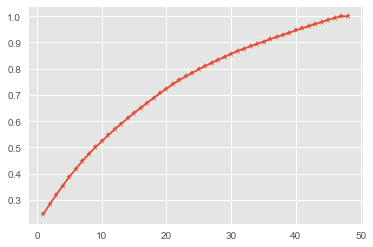

In [18]:
# The total variance explained by first K principle components

explained_variance_by_k = pca.explained_variance_ratio_.cumsum()
plt.plot(range(1,len(explained_variance_by_k)+1),explained_variance_by_k,marker="*")

In [19]:
def show_clusters(items_rotated,labels):
    
    fig = plt.figure(figsize=(15, 15))
    colors =  itertools.cycle (["b","g","r","c","m","y","k"])

    grps = items_rotated.groupby(labels)
    for label,grp in grps:
        plt.scatter(grp.pc1,grp.pc2,c=next(colors),label = label)

        names = item.loc[ grp.index,"Item_name"]
        for index, name in enumerate(names):
            print("\t<{}> {}".format(index+1,name))

    # Annotate
    for itemid in items_rotated.index:
        x = items_rotated.loc[itemid,"pc1"]
        y = items_rotated.loc[itemid,"pc2"]
        name = item.loc[itemid,"Item_name"]
        name = re.sub('\W', ' ', name)
        plt.text(x,y,name)


In [20]:
def cluster(n_clusters,n_components=48):
    
    print("first {} PC explain {:.1f}% variances".format(n_components,
                                                         100 * sum(pca.explained_variance_ratio_[:n_components])))

    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(items_rotated.values[:, :n_components])

    show_clusters(items_rotated, kmeans.labels_)

In [21]:
# Choose best K 
inertias = []
silhouettes = []

ks = range(2,30)
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(items_rotated)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(items_rotated, kmeans.predict(items_rotated)))

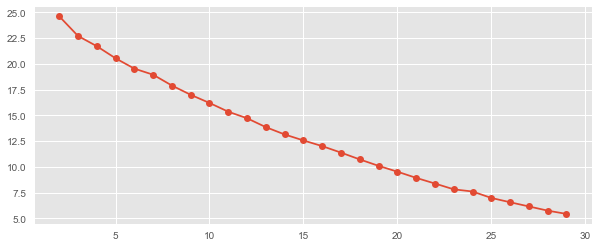

In [22]:
fig = plt.figure(figsize=(10,4))
plt.plot(ks, inertias,marker='o')

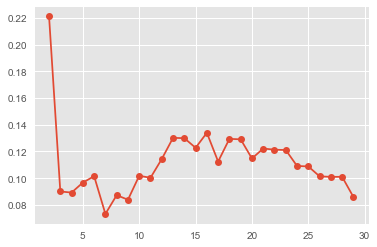

In [23]:
plt.plot(ks,silhouettes,marker='o')

In [24]:
import re
re.compile('<title>(.*)</title>')

re.compile(r'<title>(.*)</title>', re.UNICODE)

first 48 PC explain 100.0% variances
	<1> sandwich bags
	<2> aluminum foil
	<3> paper towels
	<4> toilet paper
	<1> lettuce
	<2> carrots
	<3> cucumbers
	<4> broccoli
	<5> cauliflower
	<1> shampoo
	<2> hand soap
	<3> soap
	<1> butter
	<2> eggs
	<3> milk
	<4> cheeses
	<5> yogurt
	<1> waffles
	<2> cereals
	<3> flour
	<1> poultry
	<2> beef
	<3> pork
	<1> laundry detergent
	<2> dishwashing 
	<1> sugar
	<2> pet items
	<3> soda
	<4> tea
	<5> juice
	<6> coffee
	<1> frozen vegetables
	<2> ice cream
	<1> grapefruit
	<2> cherries
	<3> apples
	<4> berries
	<5> bananas
	<1> pasta
	<1> spaghetti sauce
	<2> canned vegetables
	<3> ketchup
	<1> baby items
	<1> bagels
	<2> tortillas
	<3> dinner rolls
	<4> sandwich loaves
	<1> shaving cream


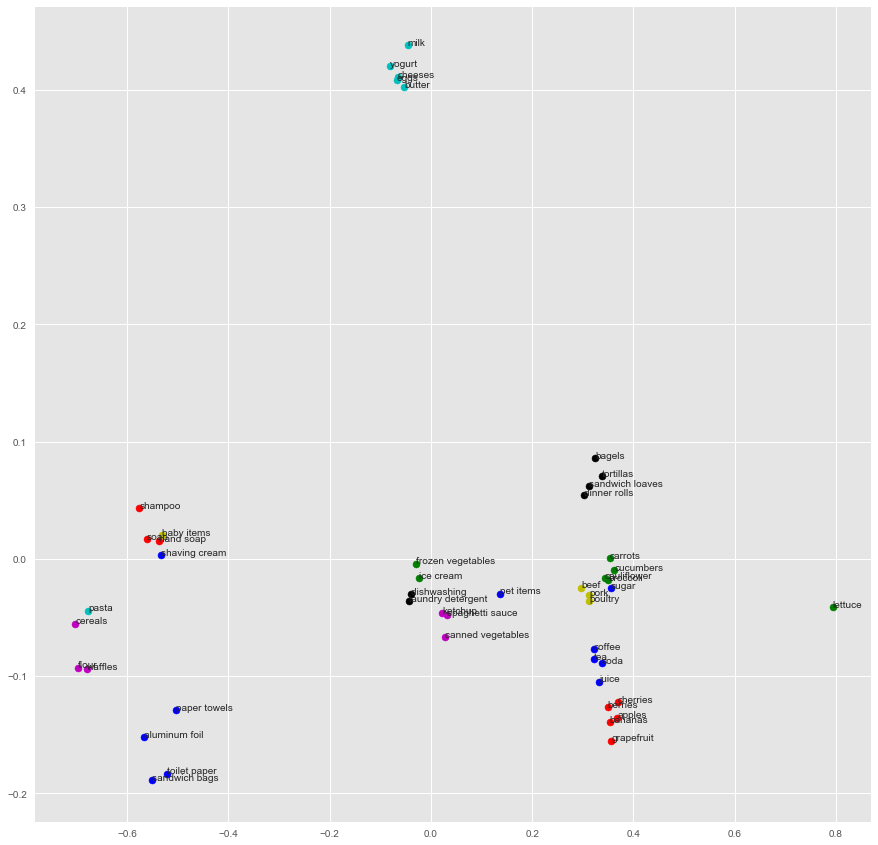

In [25]:
x=cluster(n_clusters=15)
x